In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import adaptive_avg_pool2d
import torch.optim as optim
from scipy.linalg import sqrtm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from torchvision import models
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

from scipy.linalg import sqrtm

import copy

In [2]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cuda')

In [4]:
imsize = 512 if device.type == 'cuda' else 256
imsize

512

In [5]:
def load_image (image_path):
  image = Image.open(image_path)
  return image

def resize_image(input_image, output_image):
  input_image_resized = input_image.resize(output_image.size)
  return input_image_resized

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
loader = transforms.Compose([
    transforms.Resize((imsize)),
    transforms.ToTensor(),
])

def process_image(image_name):
    image = loader(image_name).unsqueeze(0)
    return image.to(device, torch.float)

style_image = load_image ("/content/drive/My Drive/Anh My/DIP/style2.jpg")
content_image = load_image("/content/drive/My Drive/Anh My/DIP/content1.jpg")
content_image_resized = resize_image(content_image, style_image)
style_img = process_image(style_image)
content_img = process_image(content_image_resized)

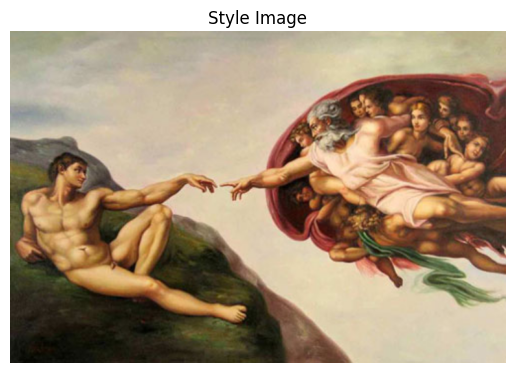

torch.Size([1, 3, 512, 766])


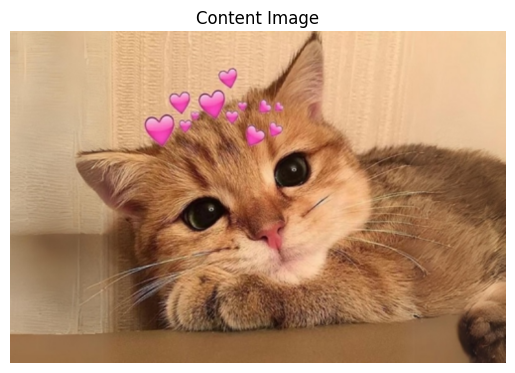

torch.Size([1, 3, 512, 766])


In [6]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')
print (style_img.shape)

plt.figure()
imshow(content_img, title='Content Image')
print (content_img.shape)

In [7]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [8]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [9]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [10]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 161MB/s]


In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [12]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn,
                               normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    content_losses = []
    style_losses = []

    normalization = Normalization (normalization_mean, normalization_std)
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

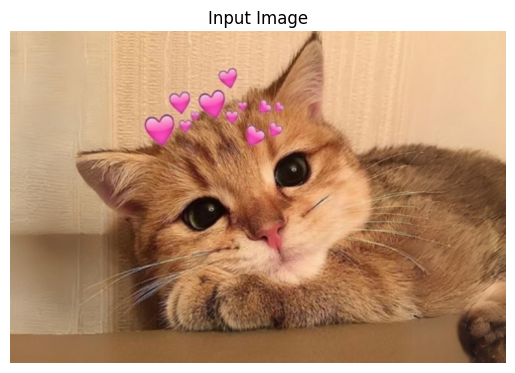

In [13]:
input_img = content_img.clone()
imshow(input_img, title='Input Image')

In [14]:
class EarlyStoppingNST:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.stop = False

    def __call__(self, current_loss):
        if self.best_loss is None:
            self.best_loss = current_loss
        elif self.best_loss - current_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_loss = current_loss
            self.counter = 0

In [15]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [16]:
def run_style_transfer(cnn,
                       normalization_mean, normalization_std,
                       content_img, style_img, input_img,
                       num_steps=1000,
                       style_weight=10000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                     normalization_mean, normalization_std,
                                                                     style_img, content_img)

    input_img.requires_grad_(True)

    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing')
    run = [0]

    min_loss = float('inf')
    best_img = input_img.clone()

    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                imshow(input_img)
                print()

            nonlocal min_loss, best_img
            if loss.item() < min_loss:
                min_loss = loss.item()
                best_img = input_img.clone()

            return loss

        loss = optimizer.step(closure).item()

    with torch.no_grad():
        input_img.clamp_(0, 1)

    print("Minimum loss achieved: {:.4f}".format(min_loss))
    print("Displaying the image at minimum loss:")
    imshow(best_img)

    return input_img


Building the style transfer model


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing
run [100]:
Style Loss : 5.351081 Content Loss: 3.683599


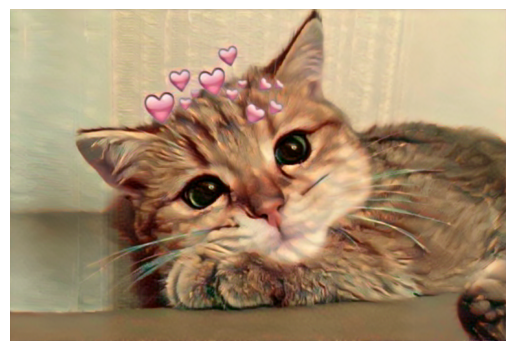


run [200]:
Style Loss : 1.898005 Content Loss: 3.151247


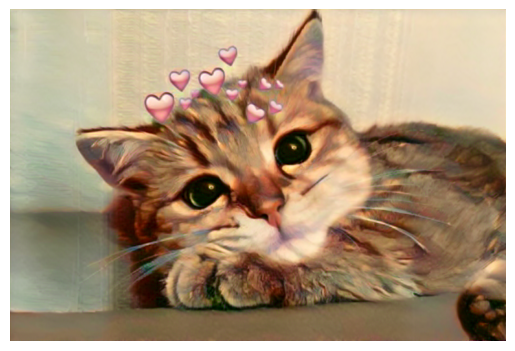


run [300]:
Style Loss : 1.140932 Content Loss: 2.807456


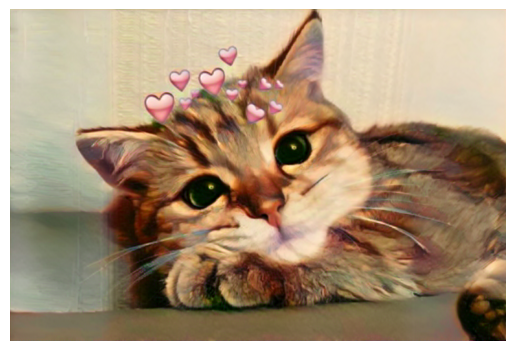


run [400]:
Style Loss : 0.673963 Content Loss: 2.702011


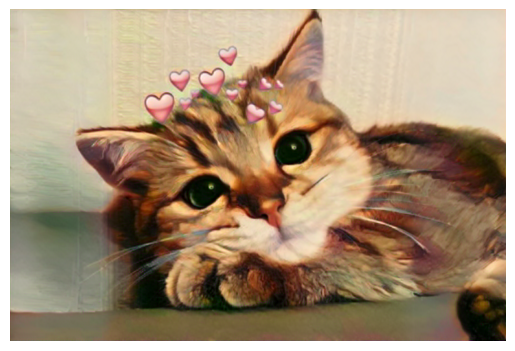


run [500]:
Style Loss : 0.492707 Content Loss: 2.615156


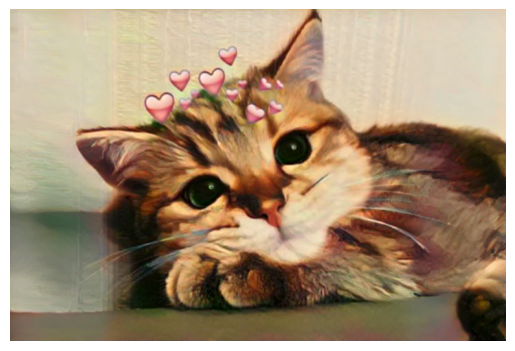


run [600]:
Style Loss : 0.428424 Content Loss: 2.553984


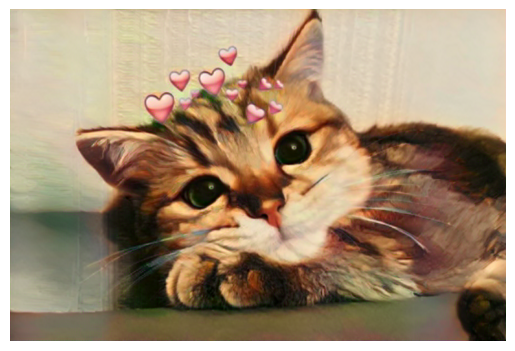


run [700]:
Style Loss : 0.388659 Content Loss: 2.519303


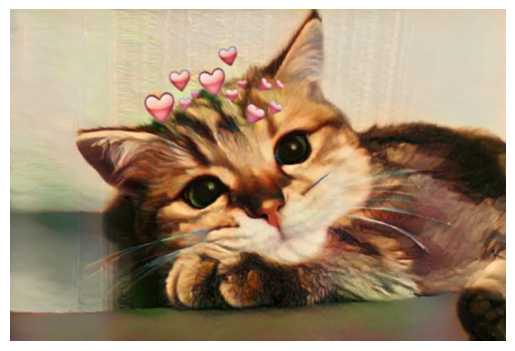


run [800]:
Style Loss : 0.362195 Content Loss: 2.499427


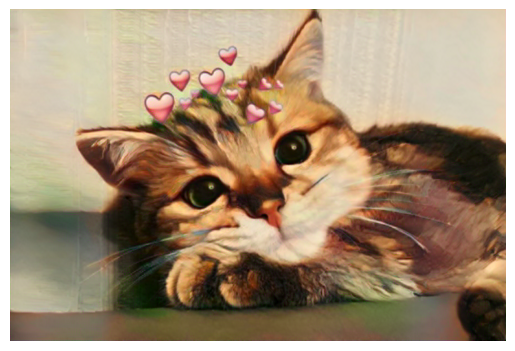


run [900]:
Style Loss : 0.341943 Content Loss: 2.487462


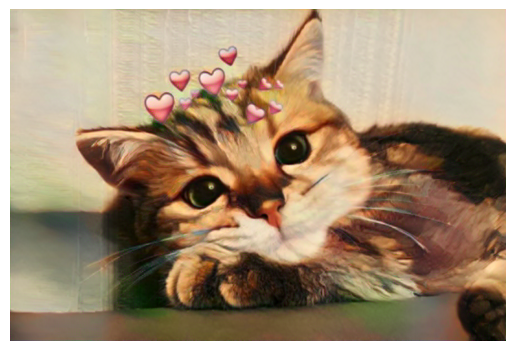


run [1000]:
Style Loss : 0.331384 Content Loss: 2.486416


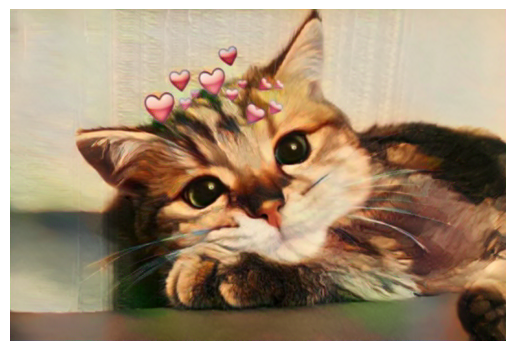


Minimum loss achieved: 2.8071
Displaying the image at minimum loss:


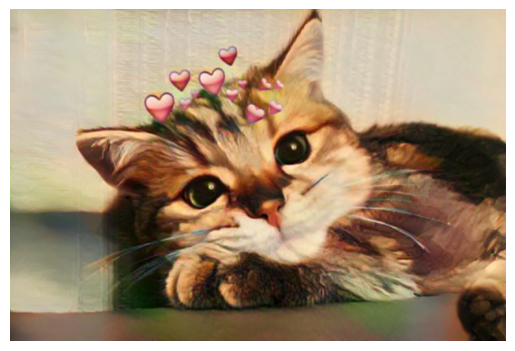

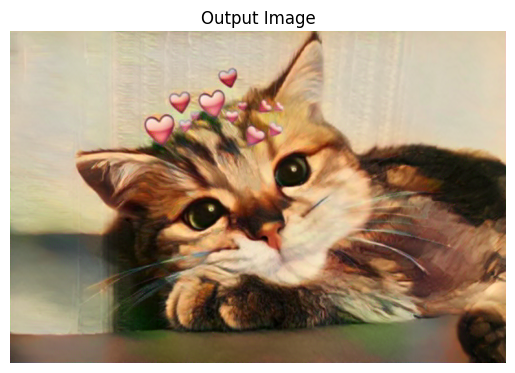

In [17]:
output = run_style_transfer(cnn,
                            cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()


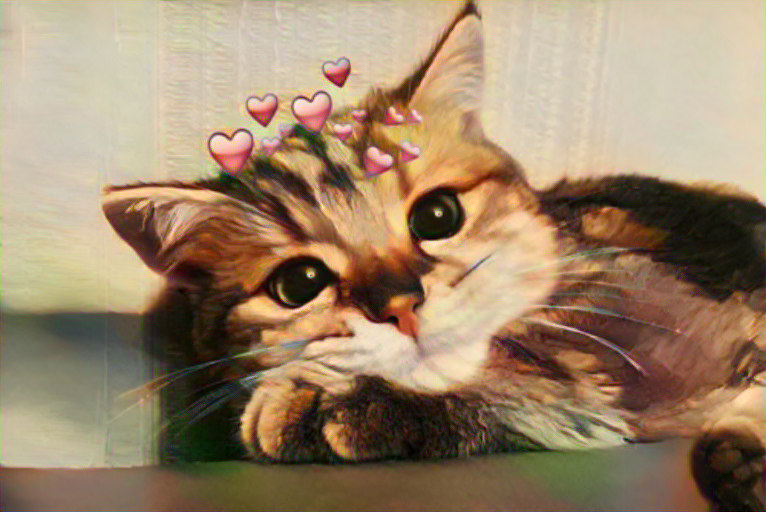

In [18]:
from google.colab.patches import cv2_imshow
output_img = output.clone()
output_img = output_img.squeeze(0)
output_img = unloader(output_img)
output_img_np = np.array(output_img)
output_img_np = output_img_np[:, :, ::-1].copy()
cv2_imshow (output_img_np)

In [19]:
def calculate_fid(real_img, generated_img, device='cuda'):
    """Calculate the Fréchet Inception Distance (FID) between two images."""
    # Load the pre-trained InceptionV3 model
    inception = models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()

    # Function to preprocess the images
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    def get_features(img):
        """Extract features from the InceptionV3 model."""
        img = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            features = inception(img)
            # The features are from the last hidden layer before the classification layer
            features = features.cpu().numpy()
        return features.flatten()

    # Get features for both real and generated images
    real_features = get_features(real_img)
    generated_features = get_features(generated_img)

    # Compute mean and covariance for both sets of features
    mu_real = np.mean(real_features, axis=0)
    mu_generated = np.mean(generated_features, axis=0)

    sigma_real = np.cov(real_features, rowvar=False)
    sigma_generated = np.cov(generated_features, rowvar=False)

    sigma_real = np.atleast_2d(sigma_real)
    sigma_generated = np.atleast_2d(sigma_generated)

    # Compute the Fréchet Inception Distance (FID)
    diff = mu_real - mu_generated
    covmean = sqrtm(sigma_real.dot(sigma_generated))  # Matrix square root
    if np.iscomplexobj(covmean):
        covmean = covmean.real  # Take real part if complex

    fid = np.sum(diff**2) + np.trace(sigma_real + sigma_generated - 2 * covmean)
    return fid

# Example usage
fid_score = calculate_fid(style_image, output_img, device='cuda')
print(f"FID Score: {fid_score}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 167MB/s]


FID Score: 0.16375777316813223
